In [6]:
import sys

sys.path.append("../networks")
sys.path.append("../")

import sqlite3

import pandas as pd
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

from functions.datamodel import OptimumParameter
from functions.env import DB_SCIENCE_PATH, GRAPH_RESULTS, DB_SCIENCE_PATH_NEW
from functions.feat_network import get_edge_node_table
from functions.feat_visualization import sygma_graph_leiden

pd.options.mode.chained_assignment = None

conn = sqlite3.connect(DB_SCIENCE_PATH_NEW)

from optimal_clustering import optimal_clustering

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)

from sklearn.metrics.pairwise import euclidean_distances


def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    return dot_product / (norm1 * norm2)


In [5]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def weighted_jaccard_similarity(matrix1, matrix2):
    """
    Compute the Weighted Jaccard Similarity between two adjacency matrices.
    """
    # Ensure matrices are numpy arrays for element-wise operations
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)

    # Calculate the minimum (intersection) and maximum (union) for each element
    min_matrix = np.minimum(matrix1, matrix2)
    max_matrix = np.maximum(matrix1, matrix2)

    # Sum the weights for intersection and union
    intersection_weight_sum = np.sum(min_matrix)
    union_weight_sum = np.sum(max_matrix)

    # Compute the similarity
    similarity = intersection_weight_sum / union_weight_sum if union_weight_sum != 0 else 0
    return similarity


def prepare_edge_list(edge1, edge2):

    matrix1 = edge1.pivot(index ='source', columns='target', values='weight')
    matrix1 = matrix1.fillna(0)

    # Add the row[i]/col[i] when there is not information
    all_occupations = list(matrix1.index)

    # Add missing occupations
    for occupation in all_occupations:
        if occupation not in matrix1.columns:
            matrix1[occupation] = 0.0  # Add new column with zeros

    # Resetting the diagonal values to 0 for existing occupations (if necessary)
    for occupation in matrix1.columns:
        matrix1.at[occupation, occupation] = 0.0

    matrix2 = edge2.pivot(index ='source', columns='target', values='weight')
    matrix2 = matrix2.fillna(0)

        # Add the row[i]/col[i] when there is not information
    all_occupations = list(matrix2.index)

    # Add missing occupations
    for occupation in all_occupations:
        if occupation not in matrix2.columns:
            matrix2[occupation] = 0.0  # Add new column with zeros

    # Resetting the diagonal values to 0 for existing occupations (if necessary)
    for occupation in matrix2.columns:
        matrix2.at[occupation, occupation] = 0.0

    labels1 = list(matrix1.index)
    labels2 = list(matrix2.index)
    common_labels = set(labels1).intersection(set(labels2))

    matrix1 = matrix1[common_labels]
    matrix1 = matrix1.reset_index()
    matrix1 = matrix1[matrix1['source'].isin(common_labels)]
    matrix1 = matrix1.set_index('source')

    matrix2 = matrix2[common_labels]
    matrix2 = matrix2.reset_index()
    matrix2 = matrix2[matrix2['source'].isin(common_labels)]
    matrix2 = matrix2.set_index('source')

    matrix1 = matrix1.loc[common_labels, common_labels]
    matrix2 = matrix2.loc[common_labels, common_labels]

    return matrix1, matrix2


def compute_jaccar_simlarity(matrix1, matrix2):

    def replace_with_one(x):
        return 1 if x >= 1 else x

    matrix1_1 = matrix1.applymap(replace_with_one)
    matrix2_1 = matrix2.applymap(replace_with_one)

    score = jaccard_score(matrix1_1.to_numpy(), matrix2_1.to_numpy(), average='weighted')
    weighted_score = weighted_jaccard_similarity(matrix1, matrix2)

    return score, weighted_score


In [22]:
## Load Data
path = 'non_europe_before_1700'

df = pd.read_csv(f"../networks/data/{path}.csv",index_col=[0])


df["meta_occupation"] = df["meta_occupation"].apply(lambda x: x.split(" | "))
df = df.explode("meta_occupation")
df = df[["wikidata_id", "meta_occupation"]]
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.columns = ["source", "target"]
df["weight"] = 1

## get co-occurence table
df = pl.from_pandas(df)
df_edge, df_nodes = get_edge_node_table(df)



datasets = {}
for edges_number in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df_edge_filter = df_edge[
        df_edge["rank_count"] <= edges_number
    ]

    df_edge_filter = df_edge_filter[['source', 'target', 'weight']]
    datasets[edges_number] = df_edge_filter
    

#df_edge_filter.to_csv(f'edges_list_filtered/{path}.csv')

# # visualization
# df_partition, g = sygma_graph_leiden(
# df_edge_filter,
# df_nodes,
# edge_bins=10,
# node_bins=10,
# filepath=f'final_graph_cache/{path}.html')

In [1]:
# Compare the ARI of the different edges

In [23]:
print(list(datasets.keys()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [24]:
# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]

        # Weighted Similary
        dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
        dataset2 = dataset2[['source', 'target', 'weight']]
        dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        try:
            score = round(score, 2)
        except:
            score = score
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
matrix_df

Dataset 2,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Dataset 1,,,,,,,,,,
1.0,1.0,0.63,0.52,0.46,0.43,0.41,0.39,0.39,0.38,0.37
2.0,0.63,1.0,0.82,0.73,0.68,0.65,0.63,0.61,0.6,0.59
3.0,0.52,0.82,1.0,0.89,0.83,0.79,0.76,0.74,0.73,0.72
4.0,0.46,0.73,0.89,1.0,0.93,0.88,0.85,0.83,0.82,0.81
5.0,0.43,0.68,0.83,0.93,1.0,0.95,0.92,0.89,0.88,0.87
6.0,0.41,0.65,0.79,0.88,0.95,1.0,0.96,0.94,0.93,0.92
7.0,0.39,0.63,0.76,0.85,0.92,0.96,1.0,0.98,0.96,0.95
8.0,0.39,0.61,0.74,0.83,0.89,0.94,0.98,1.0,0.98,0.97
9.0,0.38,0.6,0.73,0.82,0.88,0.93,0.96,0.98,1.0,0.99


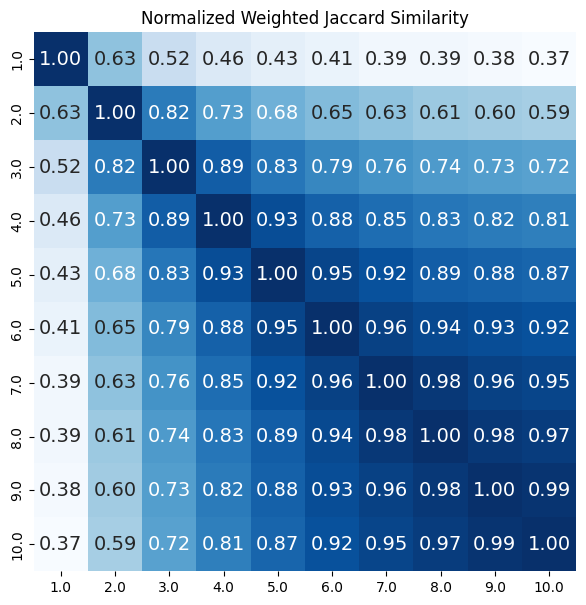

In [25]:

plt.figure(figsize=(7, 7))
#sns.heatmap(matrix_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
sns.heatmap(matrix_df.astype(float), cmap='Blues', annot=True, fmt=".2f", 
                 cbar=False, annot_kws={"size": 14})  # Increase font size here

plt.xlabel('')
plt.ylabel('')
plt.title('Normalized Weighted Jaccard Similarity')
plt.show()